# Problem Set - AS–AD Model (Closed and Open Economy) - comments/solutions

### Programming for Economists Autumn 2025: Classes 5 & 9
**Matias BF Hall**


**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Baseline static equilibrium (closed economy)](#toc2_)    
- 3. [Slope diagnostics: analytical vs numerical](#toc3_)    
- 4. [Write your own grid solver](#toc4_)    
- 5. [Comparative statics: demand vs supply shocks (closed)](#toc5_)    
- 6. [Simulation & reproducibility with seeds](#toc6_)    
  - 6.1. [Same seed → identical shocks and paths](#toc6_1_)    
  - 6.2. [Different seeds → different shocks](#toc6_2_)    
  - 6.3. [Impulse vs stochastic runs (same seed, different mode)](#toc6_3_)    
- 7. [Tiny policy search over $(a_1,a_2)$](#toc7_)    
  - 7.1. [Build AR(1) shocks for demand and supply](#toc7_1_)    
  - 7.2. [Simulate with a given rule and compute quadratic loss](#toc7_2_)    
  - 7.3. [Tiny grid search over $(a_1, a_2)$ and heatmap](#toc7_3_)    
- 8. [Open economy: fixed vs flexible (static)](#toc8_)    
- 9. [Optional: Peg vs float under persistent cost pressure](#toc9_)    
  - 9.1. [Set up a supply dominated stochastic scenario](#toc9_1_)    
  - 9.2. [Compare volatility of output and inflation](#toc9_2_)    
  - 9.3. [Plot and interpret the stochastic paths](#toc9_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Setup](#toc0_)
**Goal.** Ensure functions/parameters are available; keep separate copies for closed vs open economy.

**Guidelines.**
- Run **01_ASAD_closed.ipynb** first, then copy `par` to `par_closed`.
- Run **02_ASAD_open.ipynb** next, then copy its `par` to `par_open`.
- If you packaged functions into modules, import them instead.


In [1]:
# We forget about the above mentioned guidelines just use the par dictionary below for both closed and open economy exercises

# --- SETUP (run once) ---
import numpy as np
import matplotlib.pyplot as plt

# Optional: cleaner plots
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Unified parameter dict used for BOTH closed and open economy code
par = dict(
    # Steady state
    ybar       = 1.0,    # potential output \bar y
    pi_star    = 0.02,   # domestic inflation target \pi^*
    pi_foreign = 0.02,   # foreign inflation (open economy anchor)

    # IS curve + Taylor rule (works for closed & flexible-rate open AD)
    b   = 0.6,    # IS sensitivity to real rate
    a1  = 1.5,    # policy response to inflation gap (>1 for Taylor principle)
    a2  = 0.10,   # policy response to output gap (>=0)

    # Phillips curve (SRAS)
    gamma = 0.4,  # slope of SRAS

    # Expectations persistence (closed-economy dynamics)
    phi = 0.7,    # persistence of expected inflation

    # Openness / exchange-rate channel (open economy)
    alpha_er = 0.50,  # extra AD stabilization under flexible ER
    beta1    = 0.50,  # AD sensitivity to real exchange rate under a peg

    # Shock dynamics for simulations (both versions can use these)
    delta   = 0.80,   # AR(1) persistence of demand shocks
    omega   = 0.15,   # AR(1) persistence of supply shocks
    sigma_x = 0.01,   # std dev of demand shock innovations
    sigma_c = 0.005   # std dev of supply shock innovations
)


# Cleaner way would be to import the par from the functions module
#from Python_scripts.functions import par

## 2. <a id='toc2_'></a>[Baseline static equilibrium (closed economy)](#toc0_)

**Goal.** Compute and plot the baseline SRAS–AD with no shocks, and adaptive expectations $\pi_e=\pi^*$. Report $(y^*,\pi^*)$.

**Steps.**
1. Call `solve_grid(pi_e=par_closed["pi_star"], v=0, s=0, p=par)`.
2. Plot AD, SRAS, LRAS; mark the equilibrium using `plot_grid(pi_e=0.02, v=0, s=0, p=par)`.

**Hints.**
- Use `pad≈0.6`, `n≈400`.


In [2]:
# Ensures automatic reloading of module
%load_ext autoreload 
%autoreload 2
# Import all necessary functions from functions.py
from Python_scripts.functions import ad_curve, sras_curve, solve_grid, plot_grid, simulate_asad,\
      plot_paths, plot_static_open, simulate_open, plot_irfs_compare


y*=0.998, pi*=0.022
Equilibrium: y*=0.9985, pi*=0.0224


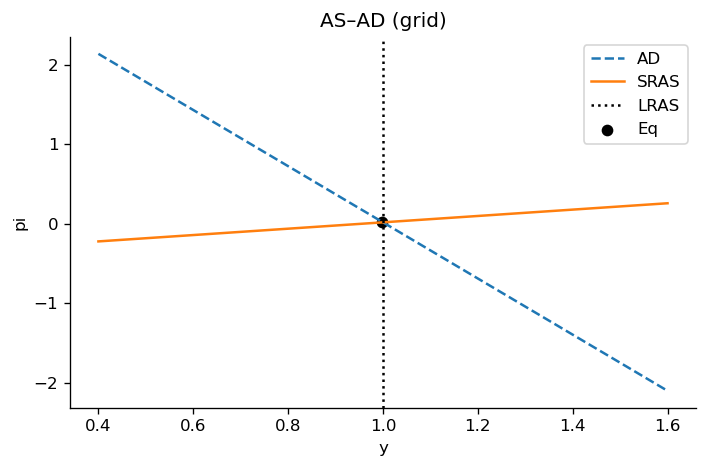

In [3]:

# STARTER — fill the lines marked TODO and run

# I simply run the code as written in the instructions above
y_star, pi_star, y, pi_ad, pi_sras = solve_grid(pi_e=par['pi_star'], v=0.0, s=0.0, p=par)
print(f'y*={y_star:.3f}, pi*={pi_star:.3f}')
# TODO: build plot with SRAS (solid), AD (dashed), LRAS (vertical at ybar), and the equilibrium marker
plot_grid(pi_e=0.02, v=0.0, s=0.0, p=par)


## 3. <a id='toc3_'></a>[Slope diagnostics: analytical vs numerical](#toc0_)

**Goal.** Verify that the **numerical** slopes at $y=\bar y$ match the **analytical** slopes.

**Setup.**  
- AD: $\pi(y)=\pi^* - \frac{(y-\bar y)-z_t}{\alpha} \Rightarrow \frac{d\pi}{dy}=-\frac{1}{\alpha}$, with $\alpha=\frac{b(a_1-1)}{1+ba_2}$.  
- SRAS: $\pi(y)=\pi_e + \gamma(y-\bar y)+s \Rightarrow \frac{d\pi}{dy}=\gamma$.

**Steps.**  
1. Compute analytical slopes from `par`.  
2. Approximate numerical slopes by centered finite differences at $y=\bar y$.  
3. Assert closeness within $10^{-3}$.

**Hints.**  
- Use `from functions import ad_curve, sras_curve` and evaluate both curves at $y=\bar y \pm h$ for a small step size $h$ (for instance $h=10^{-5}$).  
- Use `np.isclose` with `atol=1e-3` to automatically check that analytical and numerical slopes are sufficiently close.


In [4]:
# STARTER: compute analytical and numerical slopes and compare

# p = par_closed              # closed-economy parameters

# --- 1) Analytical slopes --------------------------------------
alpha_ad = np.dot(par['b'],(par['a1']-1.0)) / (1.0 + np.dot(par['b'], par['a2']))           # compute the AD sensitivity parameter from p
slope_ad_analytical   = -1.0 / alpha_ad # analytical slope of AD at y = ybar
slope_sras_analytical = par['gamma'] # analytical slope of SRAS at y = ybar

# --- 2) Numerical slopes (centered differences around y0) ------
h    = 1e-5
y0   = par["ybar"]
exp_inflation = par["pi_star"]
v = 0.0          # demand disturbance
s = 0.0          # supply disturbance
y = np.array([y0 - h, y0 + h])  # small grid around y0

inflation = ad_curve(y, p=par, v=v) # AD curve
infl_plus_ad  = inflation[1]
infl_minus_ad = inflation[0]
slope_ad_num  = (infl_plus_ad - infl_minus_ad) / (2.0 * h)     # use a centered difference around y0 
# formula: (f(x+h) - f(x-h)) / (2h) or more generally (f(x2) - f(x1)) / (x2 - x1)

inflation = sras_curve(y, p=par, pi_e=exp_inflation, s=s) # SRAS curve
infl_plus_sras  = inflation[1]
infl_minus_sras = inflation[0]
slope_sras_num  = (infl_plus_sras - infl_minus_sras) / (2.0 * h)     # use a centered difference around y0 

print("AD   slope: analytical =", slope_ad_analytical,
       "| numerical =", slope_ad_num)
print("SRAS slope: analytical =", slope_sras_analytical,
      "| numerical =", slope_sras_num)

assert np.isclose(slope_ad_num,   slope_ad_analytical,   atol=1e-3), "Mismatch in AD slope"
assert np.isclose(slope_sras_num, slope_sras_analytical, atol=1e-3), "Mismatch in SRAS slope"


AD   slope: analytical = -3.533333333333333 | numerical = -3.5333333333368087
SRAS slope: analytical = 0.4 | numerical = 0.4000000000004


## 4. <a id='toc4_'></a>[Write your own grid solver](#toc0_)

**Goal.** Implement a simple equilibrium finder **without** calling `solve_grid` or `solve_grid_fine`.

You approximate the static equilibrium by searching over a dense $y$-grid and finding where AD and SRAS are closest.

**Steps.**

1. **Build a $y$-grid around $\bar y$.**  
   Let $\bar y = par["ybar"]$. Choose a padding `pad` and a grid size `n$.
   $$
   y_{\min} = (1 - \text{pad}) \,\bar y, \quad
   y_{\max} = (1 + \text{pad}) \,\bar y
   $$
   Then construct
   $$
   y_{\text{grid}} = \text{linspace}(y_{\min}, y_{\max}, n).
   $$

2. **Evaluate AD and SRAS on the grid.**  
   - Use `ad_curve(y_grid, par, v=0.0)` to get $\pi_{ad}(y)$ on the whole grid.  
   - Use `sras_curve(y_grid, par, pi_e, s=0.0)` with $pi\_e = par["pi_star"]$ to get $\pi_{sras}(y)$.
   - Compute the absolute gap
     $$
     d(y) = \bigl|\pi_{ad}(y) - \pi_{sras}(y)\bigr|
     $$
     and find the index $i^*$ where $d(y)$ is minimal.

3. **Return $(y^*, \pi^*)$.**  
   $$
   y^* = y_{\text{grid}}[i^*], \qquad
   \pi^* = \pi_{ad}(y^*)
   $$
   Define a function (for example `solve_grid_basic(par)`) that returns this pair.

**Hints.**

- If $a_1 \le 1$ (`par["a1"]`), print a warning that the Taylor principle is violated.
- Reasonable choices: $n \ge 400$ and `pad ≈ 0.6`.


In [ ]:
# Comment multiple line below by selecting them and pressing Ctrl+K Ctrl+C in succession
# Uncomment multiple lines below by selecting them and pressing Ctrl+K Ctrl+U in succession

# Before anything i add pad and n as parameters to the par dictionary, so we can use par as the only argument in the function

par['pad'] = 0.6
par['n']   = 400
par['v']   = 0.0
par['s']   = 0.0

# STARTER: simple grid-based equilibrium finder (no call to solve_grid)

def solve_grid_linear(params):
    """
    Find a static AD–SRAS equilibrium on a dense y-grid.
    Return y_star, infl_star.
    """
    # startercode uses p a lot so rename par to p for simplicity
    p = params

    # Unpack parameters
    pi_e = p["pi_star"]  # expected inflation
    v    = p["v"]        # demand shock
    s    = p["s"]        # supply shock
    pad  = p["pad"]      # grid padding around ybar, essentially how far from the solution(LRAS) we draw AD and SRAS curves on either side
    n    = p["n"]        # number of grid points

    # 1) Warn if Taylor principle is violated
    if p["a1"] <= 1.0:
        print("Warning: a1 <= 1 (weak policy)")

    # 2) Build y-grid around steady-state output ybar
    ybar  = p["ybar"]
    y_min = (1.0 - pad) * ybar
    y_max = (1.0 + pad) * ybar
    y_grid = np.linspace(y_min, y_max, n)

    # 3) Evaluate AD and SRAS inflation on the grid
    infl_ad   = ad_curve(y_grid, p, v)
    infl_sras = sras_curve(y_grid, p, pi_e, s)

    # 4) Find the index where the two curves are closest
    diff   = np.abs(infl_ad - infl_sras)
    i_star = int(np.argmin(diff))

    # 5) Read off equilibrium output and inflation
    y_star    = float(y_grid[i_star])
    infl_star = float(infl_ad[i_star])   # or infl_sras[i_star]
    #infl_star = float(infl_sras[i_star])   # or infl_ad[i_star]
    # For same result as solve_grid, take average of the two at the equilibrium index
    # infl_star = 0.5 * (float(infl_ad[i_star]) + float(infl_sras[i_star]))

    # Retroactively after reading question 5, i added more returns below
    return y_star, infl_star, y_grid, infl_ad, infl_sras



# # After implementing the function above, you can (optionally) compare to the
# # reference solver:
y1, infl1, *_ = solve_grid_linear(params=par)
y2, infl2, *_ = solve_grid(pi_e=par["pi_star"], v=0.00, s=0.0, p=par)
print("ours:", f'y= {y1:.3f}, pi= {infl1:.3f}', "| reference:", f'y= {y2:.3f}, pi= {infl2:.3f}')

# The reference pi is different because it uses the average of infl_ad and infl_sras at the equilibrium index instead of just
# inflation at one of the curves. Increasing the number of grid points, n, would reduce the difference.


ours: y= 0.998, pi= 0.025 | reference: y= 0.998, pi= 0.022


## 5. <a id='toc5_'></a>[Comparative statics: demand vs supply shocks (closed)](#toc0_)

**Goal.** Compare the baseline equilibrium with two shock scenarios in the **closed economy** and interpret how $y$ and $\pi$ move.

Consider:
- A positive demand shock: $v = 0.02$, $s = 0$  
- A positive supply shock: $v = 0$, $s = 0.1$

**What to do.**

1. Use your equilibrium solver to find $(y, \pi)$ for:
   - Baseline: $v = 0$, $s = 0$
   - Demand shock: $v = 0.02$, $s = 0$
   - Supply shock: $v = 0$, $s = 0.1$

2. Plot AD and SRAS for each case in one figure:
   - Keep $\pi_e = \pi^*$ in all three cases.
   - Mark the three equilibria clearly (baseline, demand, supply).

3. Briefly describe:
   - How $y$ and $\pi$ change under the demand shock.  
   - How $y$ and $\pi$ change under the supply shock.  

**Hints.**

- Reuse your existing solver (for example `solve_grid` or your own grid solver) and your plotting code from the earlier exercises.  
- Use the same parameter set `par` and only change $v$ or $s$ while keeping everything else fixed.


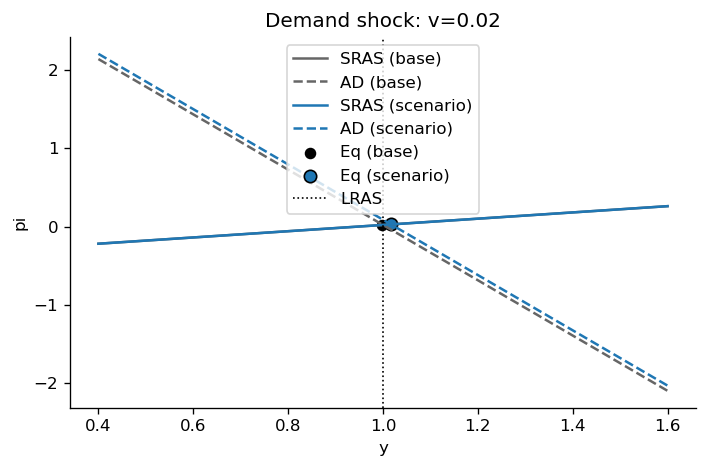

Baseline:  y=0.9985, pi=0.0253
Scenario:  y=1.0165, pi=0.0282


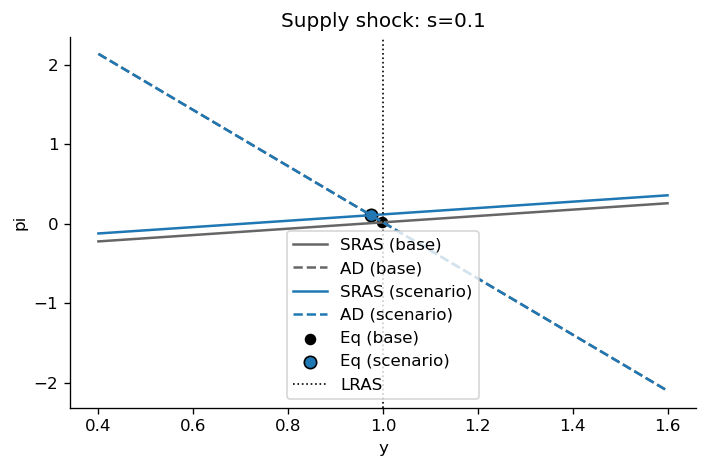

Baseline:  y=0.9985, pi=0.0253
Scenario:  y=0.9744, pi=0.1103


In [6]:
# Create two dictionaries one for demand shock and one for supply shock
par_demand_shock = par.copy()
par_demand_shock['v'] = 0.02

par_supply_shock = par.copy()
par_supply_shock['s'] = 0.1



# STARTER: overlay baseline and one shock scenario in the closed economy
# To receate the plots one-to-one(colour etc.) I simply looked at the code in A4

def plot_overlay_closed(par_base, par_scenario, title):

    # Checking that parameters set in input dictionaries are correct
    assert 'v' in par_scenario and 's' in par_scenario, "par_scenario must contain 'v' and 's'"
    assert par_base['v'] == 0.0 and par_base['s'] == 0.0, "par_base must be baseline (v=0, s=0)"
    assert par_base['pad'] == par_scenario['pad'], "par_base and par_scenario must have the same 'pad'"
    assert par_base['n'] == par_scenario['n'], "par_base and par_scenario must have the same 'n'"
    
    # Compute equilibria for baseline and scenario
    y_base, pi_base, y_grid, pi_ad_base, pi_sras_base = solve_grid_linear(params=par_base)
    y_scen, pi_scen, _, pi_ad_scen, pi_sras_scen = solve_grid_linear(params=par_scenario)

    # Build plot
    fig, ax = plt.subplots(figsize=(6,4))

    # Baseline
    ax.plot(y_grid, pi_sras_base, color="#666666", label="SRAS (base)")
    ax.plot(y_grid, pi_ad_base,   color="#666666", label="AD (base)", ls="--")
    # Scenario
    ax.plot(y_grid, pi_sras_scen, color="#1f77b4", label="SRAS (scenario)")
    ax.plot(y_grid, pi_ad_scen,   color="#1f77b4", label="AD (scenario)", ls="--")
    # Equilibrium markers
    ax.scatter([y_base], [pi_base], color="k", s=35, label="Eq (base)")
    ax.scatter([y_scen], [pi_scen], facecolor="#1f77b4", edgecolor="k", s=55, label="Eq (scenario)")
    #LRAS
    ax.axvline(par_base["ybar"], color="k", ls=":", lw=1.0, label="LRAS")
    # Cosmetics
    ax.set_xlabel("y"); ax.set_ylabel("pi"); ax.set_title(title)
    ax.legend(); plt.tight_layout(); plt.show()

    # Print equilibrium values
    print(f"Baseline:  y={y_base:.4f}, pi={pi_base:.4f}")
    print(f"Scenario:  y={y_scen:.4f}, pi={pi_scen:.4f}")

# Plot using the function above
plot_overlay_closed(par, par_demand_shock, title="Demand shock: v=0.02")
plot_overlay_closed(par, par_supply_shock, title="Supply shock: s=0.1")

## 6. <a id='toc6_'></a>[Simulation & reproducibility with seeds](#toc0_)

**Goal.** Understand how random **seeds** affect simulations in the AS–AD model:  
same seed → same shocks and paths; different seeds → different realizations.  
You will explore this in three small sub-exercises.

**Sub-exercises.**

- **5.1 Same seed.** Run the **stochastic** simulator twice with the same seed and show that shocks and paths $(v_t, s_t, y_t, \pi_t)$ are exactly identical (numerically and in plots).

- **5.2 Different seeds.** Change the seed and show that the new stochastic run produces different shocks and paths. Visualize the difference in at least one shock series.

- **5.3 Impulse vs stochastic.** With a fixed seed, compare an **impulse** run (one-time demand shock) to a **stochastic** run (many random shocks) and discuss how the dynamics of $y_t$ and $\pi_t$ differ.

**Hints.**

- Use the `seed` argument in `simulate_asad` to control randomness and `np.array_equal` to test exact equality of arrays.  
- Reuse `plot_paths` (or your own plotting code) to illustrate how seeds and experiment types affect the simulated time paths.


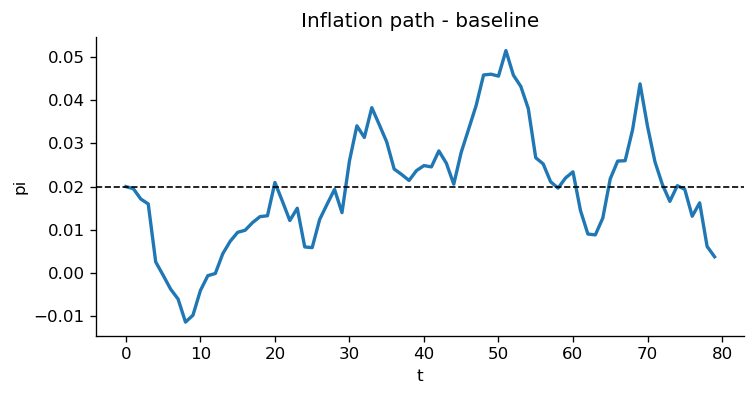

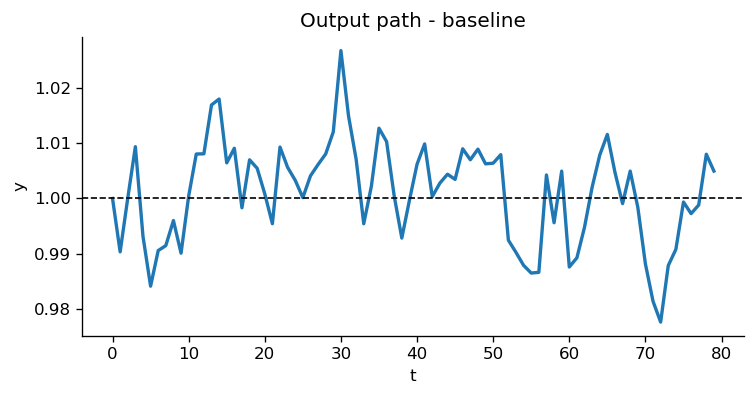

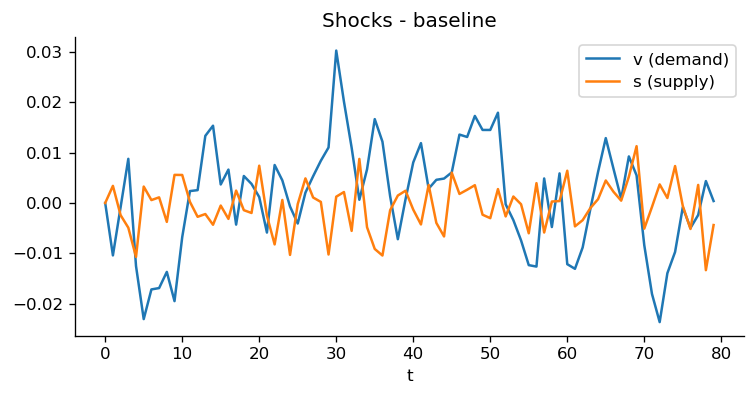

In [7]:
# STARTER — run simulate_asad twice with same seed; then change seed
# seems this was left in by mistake. Go to 6.1(5.1)

# Run with same seed and save results
res1 = simulate_asad(T=80, pars=par, mode="stochastic", seed=42)
res2 = simulate_asad(T=80, pars=par, mode="stochastic", seed=42)
# check that all arrays are equal
assert np.array_equal(res1["v"], res2["v"]) and np.array_equal(res1["s"], res2["s"])\
and np.array_equal(res1["y"], res2["y"]) and np.array_equal(res1["pi"], res2["pi"])
res3 = simulate_asad(T=80, pars=par, mode="stochastic", seed=43)
assert not np.array_equal(res1["v"], res3["v"]) or not np.array_equal(res1["s"], res3["s"])\
or not np.array_equal(res1["y"], res3["y"]) or not np.array_equal(res1["pi"], res3["pi"])

# TODO: Plot an impulse vs stochastic path (use plot_paths)

# plot_paths is not setup to handle multiple scenarios yet, so just plot the baseline and move on to next section
plot_paths(res1, title_suffix='- baseline')


### 6.1. <a id='toc6_1_'></a>[Same seed → identical shocks and paths](#toc0_)

**Goal.** Show that using the same random seed in the stochastic AS–AD simulation reproduces exactly the same shock sequences and simulated paths $(v_t, s_t, y_t, \pi_t)$.

**What to do.**
1. Run `simulate_asad` twice with the **same** seed (for example `seed=123`).
2. Check with `np.array_equal` that both draws and paths are identical.
3. Produce a simple plot where the two series lie exactly on top of each other (for example $v_t$ and $y_t$ from both runs).


Same seed → shocks and paths are identical.


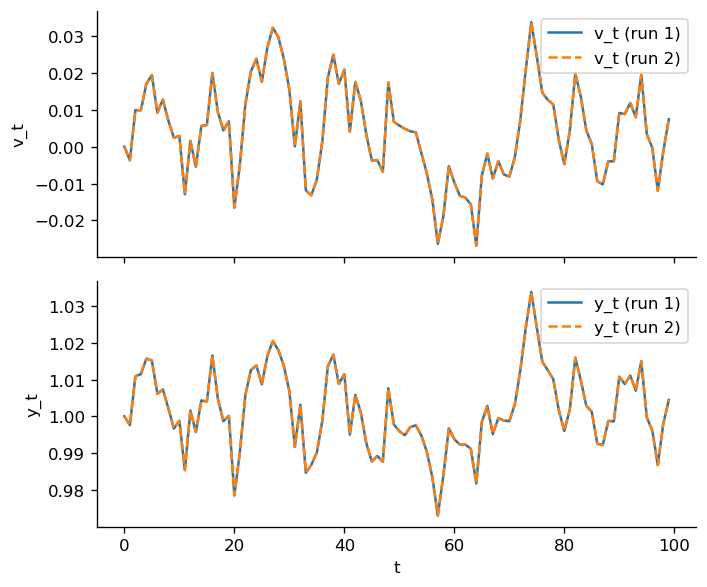

In [8]:
# STARTER 5.1 — same seed, same results
# I removed code that was redundant such as imporsts already done above

# two stochastic runs with the same seed
sto1 = simulate_asad(T=100, pars=par, mode="stochastic", seed=123)
sto2 = simulate_asad(T=100, pars=par, mode="stochastic", seed=123)

# 1) check equality of shocks and paths
assert np.array_equal(sto1["v"], sto2["v"]) and np.array_equal(sto1["s"], sto2["s"])
assert np.array_equal(sto1["y"], sto2["y"]) and np.array_equal(sto1["pi"], sto2["pi"])
print("Same seed → shocks and paths are identical.")

# 2) plot one shock series and one macro variable from both runs

# Explanation:
# the simulate_asad function computes shock paths following an AR(1) process
# with normally distributed innovations(new shock every period).
# then it computes the equilibrium output and inflation paths given these shocks.
# below those paths are accessed from the returned dictionaries and plotted for comparison.

fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
axes[0].plot(sto1["v"], label="v_t (run 1)")
axes[0].plot(sto2["v"], ls="--", label="v_t (run 2)")
axes[0].set_ylabel("v_t"); axes[0].legend()
axes[1].plot(sto1["y"], label="y_t (run 1)")
axes[1].plot(sto2["y"], ls="--", label="y_t (run 2)")
axes[1].set_xlabel("t"); axes[1].set_ylabel("y_t"); axes[1].legend()
plt.tight_layout(); plt.show()

### 6.2. <a id='toc6_2_'></a>[Different seeds → different shocks](#toc0_)

**Goal.** Show that changing the seed produces a different realization of shocks, and hence different simulated paths.

**What to do.**
1. Reuse one of the runs from 5.1 (for example `seed=123`).
2. Run `simulate_asad` again with a **different** seed (for example `seed=456`).
3. Compare the two shock arrays with `np.array_equal` and show that they differ.
4. Plot the two $v_t$ sequences in one figure to make the difference visible.


Same seed → shocks identical: True
Different seed → shocks identical: False


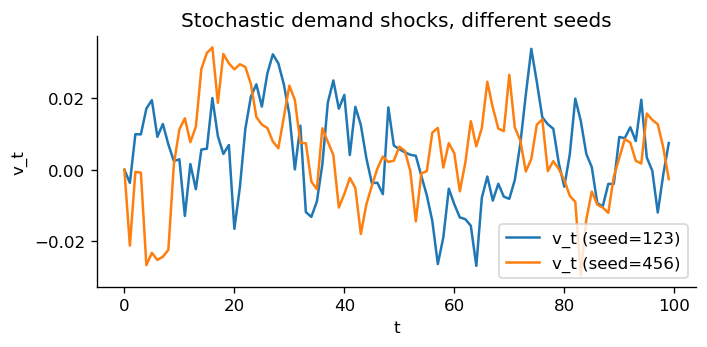

In [9]:
# STARTER 5.2 — different seeds, different shocks
# All necessary code was here, come and ask if anything is unclear

# first stochastic run (reuse or rerun)
sto1 = simulate_asad(T=100, pars=par, mode="stochastic", seed=123)

# second stochastic run with a different seed
sto3 = simulate_asad(T=100, pars=par, mode="stochastic", seed=456)

# 1) check whether shocks are identical or not
same_v = np.array_equal(sto1["v"], sto3["v"])
same_s = np.array_equal(sto1["s"], sto3["s"])
print("Same seed → shocks identical:", True)
print("Different seed → shocks identical:", same_v and same_s)

# 2) plot v_t for both seeds
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(sto1["v"], label="v_t (seed=123)")
ax.plot(sto3["v"], label="v_t (seed=456)")
ax.set_xlabel("t"); ax.set_ylabel("v_t")
ax.set_title("Stochastic demand shocks, different seeds")
ax.legend(); plt.tight_layout(); plt.show()


### 6.3. <a id='toc6_3_'></a>[Impulse vs stochastic runs (same seed, different mode)](#toc0_)

**Goal.** Compare a one–time **impulse** experiment to a fully **stochastic** simulation, using the same seed for reproducibility.

**What to do.**
1. Run an impulse experiment with `mode="impulse"` (for example a demand shock of size $0.02$ at $t=0$).
2. Run a stochastic experiment with `mode="stochastic"` and the **same** seed.
3. Use `plot_paths` (or your own plots) to visualize the very different dynamics of $y_t$ and $\pi_t$ in the impulse vs stochastic case.


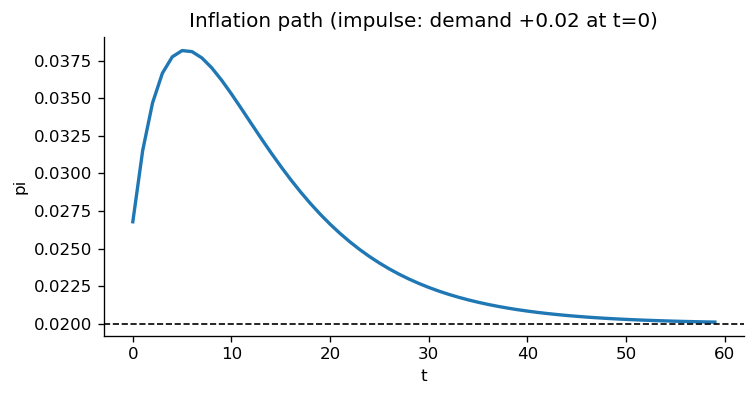

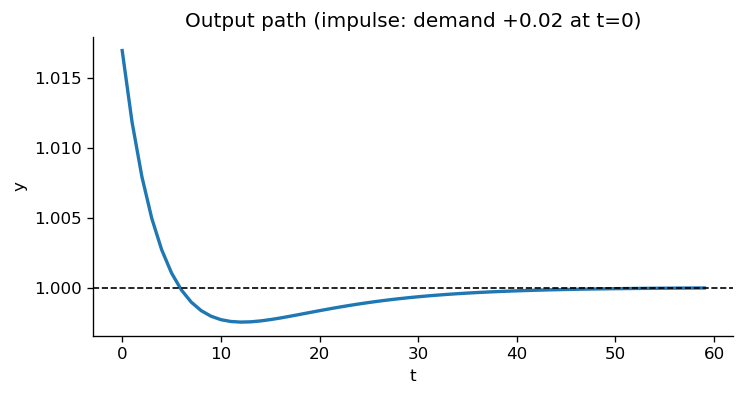

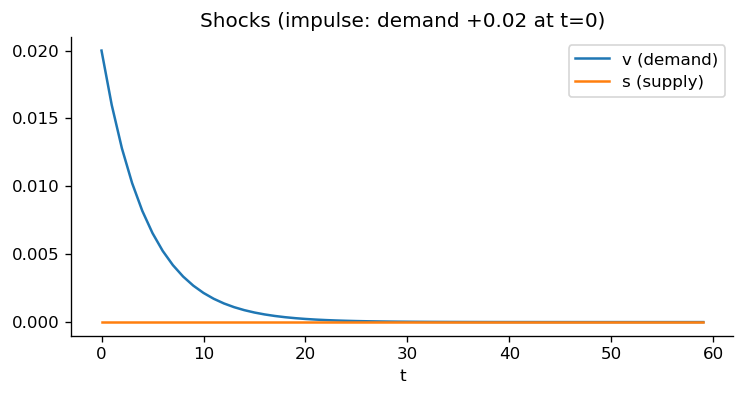

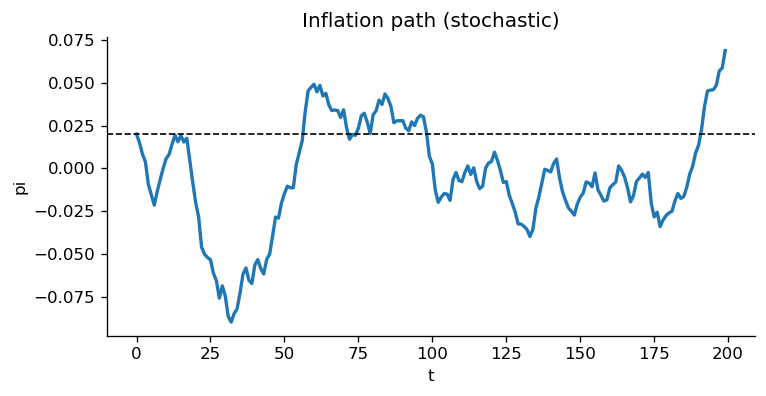

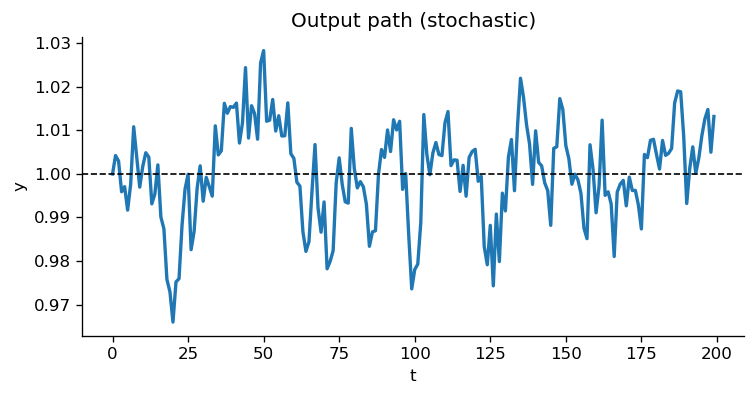

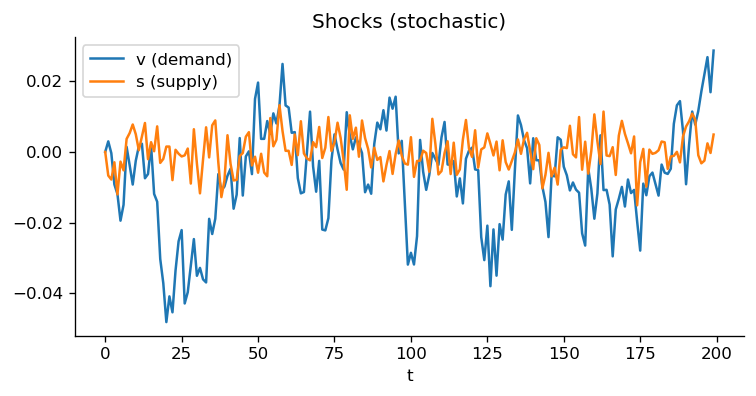

In [10]:
# STARTER 5.3 — impulse vs stochastic

# Explanation:
# when mode="impulse", simulate_asad applies a one-time shock of given size at t=0
# the shock still follows the AR(1) process afterwards, but there are no new innovations
# which choses if the shock is on the demand side ("demand") or supply side ("supply")
# size is the initial size of the shock at t=0

# impulse run: single demand shock at t = 0
imp_d = simulate_asad(
    T=60,
    pars=par,
    mode="impulse",
    which="demand",
    size=0.02,
    seed=7,
)

# stochastic run: many random shocks
sto = simulate_asad(
    T=200,
    pars=par,
    mode="stochastic",
    seed=7,
)

# plot both experiments
plot_paths(imp_d, title_suffix="(impulse: demand +0.02 at t=0)")
plot_paths(sto,   title_suffix="(stochastic)")

# See the plots for yourself below and compare the impulse response to the stochastic path.
# Try to explain the movement in inflation and output for the impulse response using mechanisms learned in ØP B or Macro II
# The stochastic path is to irregular to have a meaningful interpretation - or at the very least would need much more analysis


## 7. <a id='toc7_'></a>[Tiny policy search over $(a_1,a_2)$](#toc0_)

**Goal.** See how the Taylor rule coefficients $(a_1,a_2)$ affect stability by choosing them to minimize a quadratic loss in a simulated sample.

**Loss function.**  
For each pair $(a_1,a_2)$, define
$$
\mathcal L(a_1,a_2)
= \sum_{t=0}^{T-1} \bigl(\pi_t - \pi^*\bigr)^2
+ \lambda \bigl(y_t - \bar y\bigr)^2,
$$
where $\lambda \ge 0$ controls how much weight you put on output gaps relative to inflation gaps.

**Steps.**

1. **Fix shocks and sample length.**  
   Choose a horizon $T$ and a seed. Generate one sequence of shocks $(v_t,s_t)$ (for example AR(1) processes) and keep it fixed for the whole policy search.

2. **Grid over policy coefficients.**  
   Build coarse grids for $a_1$ and $a_2$ (for example a few values around the baseline). For each pair $(a_1,a_2)$:
   - update `par["a1"]` and `par["a2"]`,
   - simulate the model with the same shock sequence,
   - compute the loss $\mathcal L(a_1,a_2)$.

3. **Pick and visualize the best policy.**  
   Store all losses in a 2D array, find the grid point with the smallest loss, and report the corresponding $(a_1^*,a_2^*)$.  
   Plot a heatmap of $\mathcal L(a_1,a_2)$ over the grid and mark the minimum.


### 7.1. <a id='toc7_1_'></a>[Build AR(1) shocks for demand and supply](#toc0_)

**Goal.** Create a helper that generates dynamic shocks $(v_t, s_t)$ using simple AR(1) processes, which you will reuse for all Taylor rule experiments.

We want
$$
v_t = \delta v_{t-1} + x_t, \quad s_t = \omega s_{t-1} + c_t,
$$
where $x_t$ and $c_t$ are i.i.d. normal shocks with standard deviations $\sigma_x$ and $\sigma_c$ taken from the parameter dictionary.

**Tasks.**

1. Write a function `make_shocks_ps(T, p, seed)` that  
   - sets up a random generator with the provided `seed`,  
   - draws $x_t$ and $c_t$,  
   - fills two arrays `v` and `s` using the AR(1) formulas.  
2. Return `v, s`. Optionally, plot them to see how persistent they are.


In [11]:
# STARTER 6.1 — AR(1) shocks for v_t and s_t

def make_shocks_ps(T, p, seed=0):
    """
    Build AR(1) processes for demand shocks v_t and supply shocks s_t.

    v_t = delta * v_{t-1} + x_t
    s_t = omega * s_{t-1} + c_t
    """

    # create random number generator with given seed
    rng = np.random.default_rng(seed)

    # generate normal shock innovations
    x = rng.normal(loc=0.0, scale=p["sigma_x"], size=T)
    c = rng.normal(loc=0.0, scale=p["sigma_c"], size=T)

    # create arrays to hold shocks
    v = np.zeros(T)
    s = np.zeros(T)

    # loop from period 1 to T-1 to build the AR(1) processes, no shock at t=0
    for t in range(1, T):
        # filled in with equations from the function docstring
        v[t] = p["delta"] * v[t-1] + x[t]
        s[t] = p["omega"] * s[t-1] + c[t]

    return v, s


In [12]:
# dynamic parameter dict for the policy search
p_dyn = {
    **par,           # copy all baseline parameters
    "delta":   0.80, # persistence of demand shock v_t
    "omega":   0.15, # persistence of supply shock s_t
    "sigma_x": 0.01, # std dev of v_t innovation
    "sigma_c": 0.005 # std dev of s_t innovation
}


### 7.2. <a id='toc7_2_'></a>[Simulate with a given rule and compute quadratic loss](#toc0_)

**Goal.** Given Taylor rule coefficients $(a_1, a_2)$ and fixed shock paths $(v_t, s_t)$, simulate the dynamic AS AD model and compute the quadratic loss
$$
\mathcal L = \sum_t (\pi_t - \pi^*)^2 + \lambda (y_t - \bar y)^2.
$$

**Tasks.**

1. Implement `simulate_with_rule_ps(a1, a2, v, s, p)` that  
   - copies the parameter dictionary `p` and overwrites `a1` and `a2`,  
   - iterates over $t$ and at each step calls `solve_grid` with current $(v_t, s_t)$ and previous expected inflation $\pi_e$,  
   - collects arrays `y` and `pi`.  
2. Implement `loss_quad_ps(y, pi, p, lam)` that returns the scalar loss for one simulation.


In [13]:
# STARTER 6.2 — simulate for (a1, a2) and compute loss

# In case you where wondering where the a1 and a2 parameters have an effect
# it is in the ad_curve function in functions.py where the ad curve is computed
# the ad curve is computed each time solve_grid is called


def simulate_with_rule_ps(a1, a2, v, s, p, pad=0.6, n=400):
    """
    Simulate the dynamic AS AD system for given Taylor rule coefficients (a1, a2)
    and given shock paths v_t, s_t.
    """
    # create dictionary, P, as a copy of p and overwriting the values under the a1 and a2 keys
    P = {**p, "a1": float(a1), "a2": float(a2)}
    
    # create arrays for storing simulation results with same length as the shock arrays
    T = len(v)
    y  = np.empty(T)
    pi = np.empty(T)
    
    # simulate period by period, using previous period's inflation as expected inflation
    pi_prev = P["pi_star"]
    for t in range(T):
        y[t], pi[t], *_ = solve_grid(
            pi_e = pi_prev,
            v    = v[t],
            s    = s[t],
            p    = P,
            pad  = pad,
            n    = n,
        )
        pi_prev = pi[t]
    
    return y, pi


def loss_quad_ps(y, pi, p, lam=0.5):
    """
    L = sum_t (pi_t - pi_star)^2 + lam * (y_t - ybar)^2
    """
    term_pi = (pi - p["pi_star"])**2
    term_y  = (y  - p["ybar"])**2
    return float(np.sum(term_pi + lam * term_y))


### 7.3. <a id='toc7_3_'></a>[Tiny grid search over $(a_1, a_2)$ and heatmap](#toc0_)

**Goal.** Use your shocks and loss function to search over a coarse grid of Taylor rule parameters and visualize which pair performs best.

**Tasks.**

1. Fix $T$, $\lambda$, and a seed. Use `make_shocks_ps` once to get $(v_t, s_t)$ and keep them fixed.  
2. Build arrays `a1_vals` and `a2_vals` with a small number of grid points.  
3. For each pair $(a_1, a_2)$, run `simulate_with_rule_ps`, compute the loss with `loss_quad_ps`, and store it in a 2D loss matrix `L`.  
4. Find the minimum in `L`, report the corresponding $(a_1, a_2)$, and plot a heatmap of `L` over the grid (mark the minimum).


In [14]:
x = np.random.rand(3,3)
i = np.argmin(x)

In [15]:
print(i)

4


In [16]:
x[i // 3, i % 3]  # to get the value at the index

np.float64(0.06779352919447512)

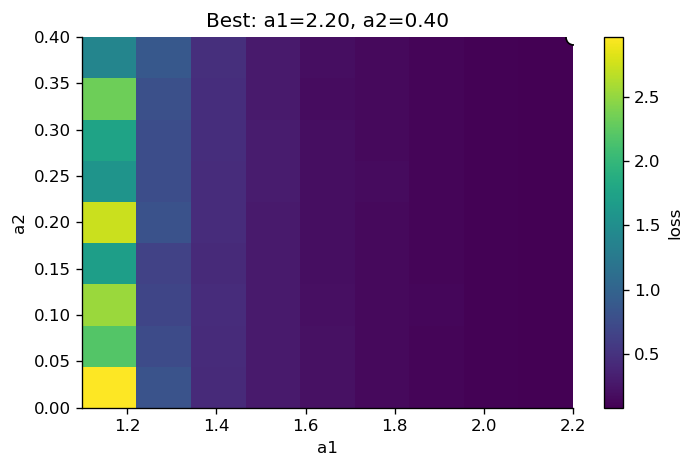

{'a1': 2.2, 'a2': 0.4, 'loss': 0.07805205104439775}


In [17]:
# STARTER 6.3 — grid search over (a1, a2) and heatmap

def tiny_grid_search_ps(p, a1_vals, a2_vals, T=150, lam=0.5, seed=1, pad=0.6, n=400):
    """
    For each (a1, a2) on a coarse grid, simulate the model with fixed shocks
    and compute the quadratic loss. Return the loss matrix and the best pair.
    """
    # generate shocks once using function created above
    v, s = make_shocks_ps(T, p, seed=seed)
    # create grid to hold losses with dimensions len(a1_vals) * len(a2_vals)
    L = np.empty((len(a1_vals), len(a2_vals)))
    
    # loop over all (a1, a2) pairs and compute simulated paths and loss
    for i, a1 in enumerate(a1_vals):
        for j, a2 in enumerate(a2_vals):
            y, pi = simulate_with_rule_ps(a1, a2, v, s, p, pad=pad, n=n)
            L[i, j] = loss_quad_ps(y, pi, p, lam)
    
    # find best (a1, a2) pair using their indices in L
    # argmin finds the flat index of the minimum value in L
    # unravel_index converts flat index to 2D index uisng the index and the shape of L
    # alternatively we could use floor division and modulo(remainder computation):
    # i0 = np.argmin(L) // L.shape[0]
    # j0 = np.argmin(L) % L.shape[1]
    i0, j0 = np.unravel_index(np.argmin(L), L.shape)
    best = {
        "a1": float(a1_vals[i0]),
        "a2": float(a2_vals[j0]),
        "loss": float(L[i0, j0]),
    }
    
    # heatmap of L over (a1, a2)
    plt.figure(figsize=(6, 4))
    plt.imshow(
        L.T,
        origin="lower",
        aspect="auto",
        extent=[a1_vals[0], a1_vals[-1], a2_vals[0], a2_vals[-1]],
    )
    plt.colorbar(label="loss")
    plt.scatter(best["a1"], best["a2"], c="w", edgecolor="k", s=80)
    plt.xlabel("a1")
    plt.ylabel("a2")
    plt.title(f"Best: a1={best['a1']:.2f}, a2={best['a2']:.2f}")
    plt.tight_layout()
    plt.show()
    
    return L, best

# Example grids you can try after implementing:
p_dyn   = {**par, "delta":0.80, "omega":0.15, "sigma_x":0.01, "sigma_c":0.005}
a1_vals = np.linspace(1.1, 2.2, 9)
a2_vals = np.linspace(0.00, 0.40, 9)
L, best = tiny_grid_search_ps(p_dyn, a1_vals, a2_vals, T=150, lam=0.5, seed=7)
print(best)


## 8. <a id='toc8_'></a>[Open economy: fixed vs flexible (static)](#toc0_)

**Goal.** Compare static equilibria under **fixed** vs **flexible** exchange-rate regimes.

**Steps.**
1. Use `plot_static_open(pi_e, v, s, p=par_open, pad=0.6)` for both regimes (helper solves per regime).
2. Try a demand shock \(v=+0.02\) and a supply shock \(s=+0.01\).

**Hints.**
- If `pi_e=None`, the helper chooses a regime-appropriate anchor.


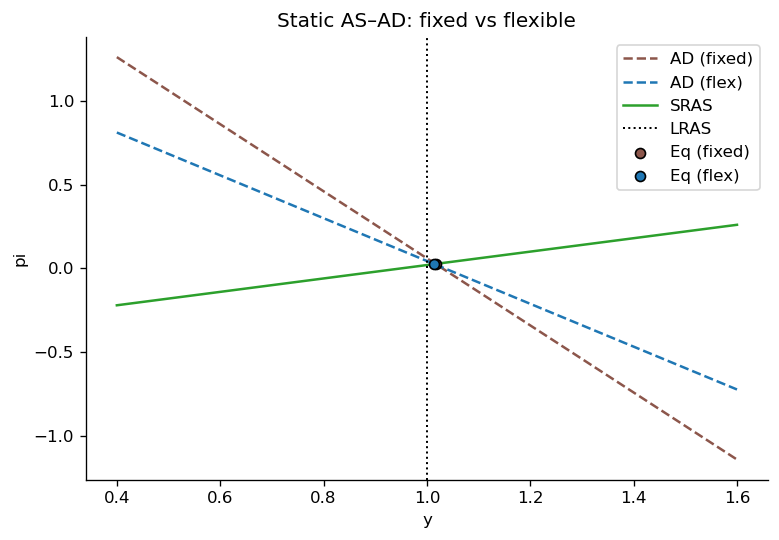

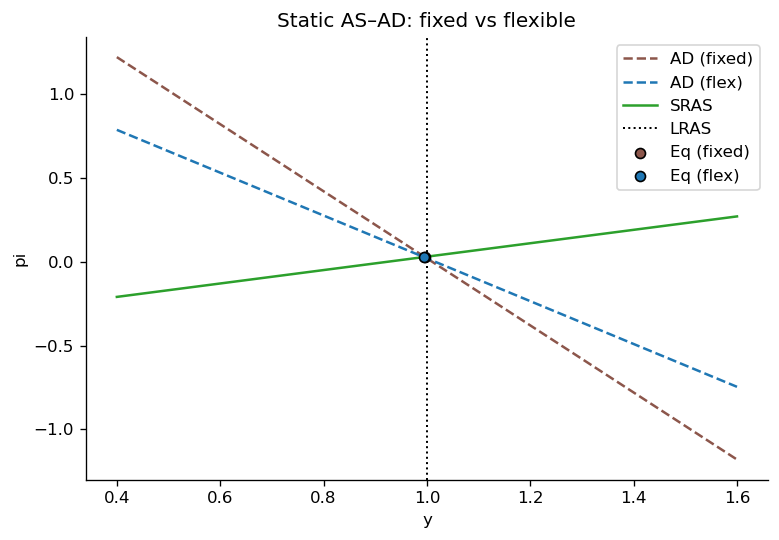

In [18]:
# STARTER — call the helper with two shock configurations
plot_static_open(pi_e=par["pi_star"], v=0.02, s=0.00, p=par, pad=0.6)
plot_static_open(pi_e=par["pi_star"], v=0.00, s=0.01, p=par, pad=0.6)
# comment with you best macro knowledge:)

## 9. <a id='toc9_'></a>[Optional: Peg vs float under persistent cost pressure](#toc0_)

**Goal.** Compare how **fixed** and **flexible** exchange rate regimes handle **persistent supply shocks** in the open economy AS AD model.

You will work with the existing simulator `simulate_open` and:

- construct a **supply dominated** stochastic scenario,
- compare **volatility** of output and inflation under a peg vs a float,
- visualize and interpret the trade off between the two regimes.


### 9.1. <a id='toc9_1_'></a>[Set up a supply dominated stochastic scenario](#toc0_)

**Goal.** Create a variant of the parameter dictionary where **supply shocks dominate** and simulate long stochastic samples under a fixed and a flexible exchange rate regime.

**What to do.**

1. Build a new parameter dictionary, for example `par_supply`, starting from `par` and making supply shocks more important than demand shocks (for instance, reduce $ \sigma_x $ and increase $ \sigma_c $).
2. Choose a horizon $T$ (for example $T=200$) and a seed.
3. Run two stochastic simulations with the **same** parameters and **same** seed:
   - one with `regime="fixed"`,
   - one with `regime="flex"`.
4. Store the results in `res_fix_sto` and `res_flex_sto` for later use.


In [19]:
# STARTER 8.1 — supply dominated stochastic simulations (fixed vs flex)

import numpy as np

# 1) Start from the baseline parameters and tilt toward supply shocks
par_supply = {**par,
              "sigma_x": par["sigma_x"]*0.5,   # smaller demand innovation
              "sigma_c": par["sigma_c"]*2,     # larger supply innovation
              "delta": par["delta"]*0.5,       # less persistent demand shocks
              "omega": par["omega"]*1.5}       # more persistent supply shocks

# 1.1) Use this dictionary instead if you prefer your results to be the same as the solution(uncomment):
"""par_supply = {
    **par,
    "sigma_x": 0.002,   # smaller demand innovations
    "sigma_c": 0.020,   # larger supply innovations
}"""

# 2) Choose horizon and seed
T = 200
seed = 2025 # I like choosing the year as seed :) If the project spans multiple years, I choose birthday year

# 3) Stochastic simulations under fixed and flexible regimes
res_fix_sto  = simulate_open(T=T, p=par_supply,
                             mode="stochastic", regime="fixed", seed=seed)
res_flex_sto = simulate_open(T=T, p=par_supply,
                             mode="stochastic", regime="flex",  seed=seed)


### 9.2. <a id='toc9_2_'></a>[Compare volatility of output and inflation](#toc0_)

**Goal.** Quantify how much $y_t$ and $\pi_t$ fluctuate under each regime when supply shocks dominate.

**What to do.**

1. Take the two results `res_fix_sto` and `res_flex_sto` from 6.1.
2. Optionally discard an initial burn in period (for example the first 20 observations) to focus on the stationary part of the simulation.
3. Compute the sample standard deviations:
   - $ \operatorname{std}(\pi_t - \pi^*) $ for each regime,
   - $ \operatorname{std}(y_t - \bar y) $ for each regime.
4. Print the four numbers in a compact summary so you can see which regime stabilizes inflation more and which one stabilizes output more.


In [20]:
# STARTER 6.2 — compute volatility under fixed vs flex

# convenience: steady state values
pi_star = par_supply["pi_star"]
ybar    = par_supply["ybar"]

# optional burn in
burn = 20
sl = slice(burn, None)

# no burn in
#burn = None
#sl = slice(burn, None)

# extract series after burn in
y_fix   = res_fix_sto["y"][sl]
y_flex  = res_flex_sto["y"][sl]
pi_fix  = res_fix_sto["pi"][sl]
pi_flex = res_flex_sto["pi"][sl]

# compute standard deviations of gaps
std_y_fix   = np.std(y_fix  - ybar)
std_y_flex  = np.std(y_flex - ybar)
std_pi_fix  = np.std(pi_fix  - pi_star)
std_pi_flex = np.std(pi_flex - pi_star)

# print results
if burn is not None:
    print(f"Volatility after burn-in of {burn} periods:")
else:
    print("Volatility without burn-in:")
print(f"Std dev output gap:   fixed = {std_y_fix:.4f},  flex = {std_y_flex:.4f}")
print(f"Std dev inflation gap: fixed = {std_pi_fix:.4f}, flex = {std_pi_flex:.4f}")

# fixed stabilizes output more, flexible stabilizes inflation more

Volatility after burn-in of 20 periods:
Std dev output gap:   fixed = 0.0110,  flex = 0.0131
Std dev inflation gap: fixed = 0.0223, flex = 0.0174


### 9.3. <a id='toc9_3_'></a>[Plot and interpret the stochastic paths](#toc0_)

**Goal.** Visualize how $y_t$ and $\pi_t$ evolve under each regime when hit by the same sequence of supply dominated shocks and relate this to the volatility measures from 6.2.

**What to do.**

1. Use `plot_irfs_compare(res_fix_sto, res_flex_sto, title_suffix="(stochastic, supply dominated)")` or create your own plots with $t$ on the horizontal axis and separate panels for inflation and output.
2. Make sure both regimes are shown in the same figure for each variable (fixed vs flex).
3. Briefly summarize what you see:
   - Which regime delivers **more stable inflation**?
   - Which regime delivers **more stable output**?
   - How does this match your standard deviation results from 8.2?


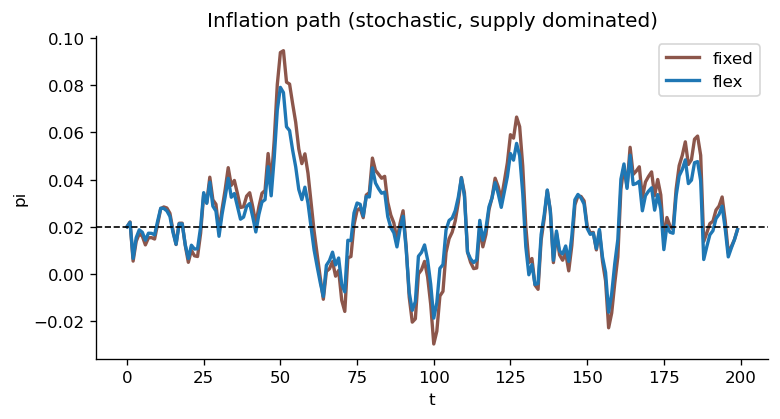

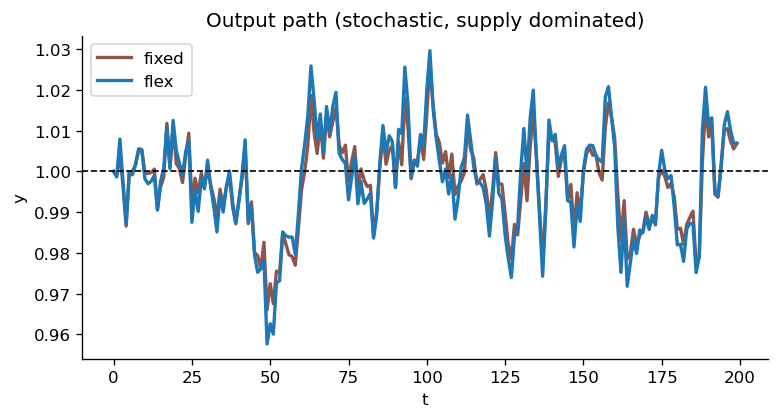

In [21]:
# STARTER 8.3 — plot and discuss

# Option A: reuse the helper
plot_irfs_compare(res_fix_sto, res_flex_sto,
                  title_suffix="(stochastic, supply dominated)")




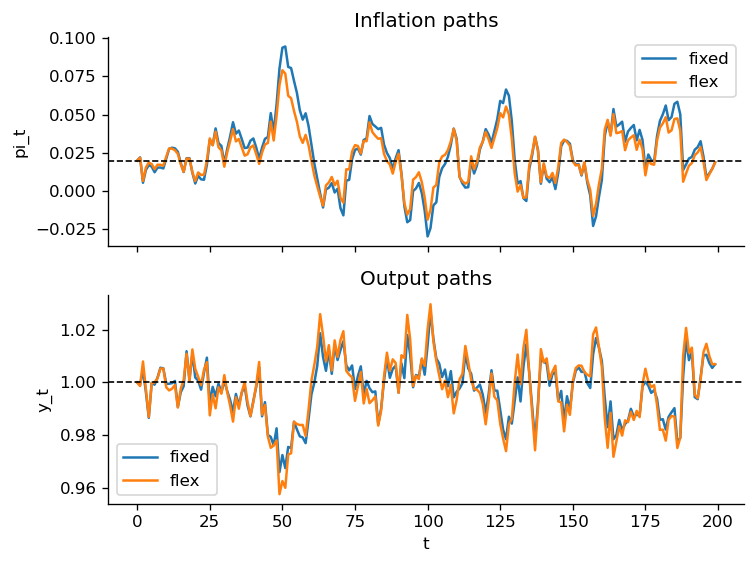

In [22]:
# Option B: write your own quick plots
T = len(res_fix_sto["y"])
t = np.arange(T)

fig, axes = plt.subplots(2, 1, figsize=(6.4, 4.8), sharex=True)

axes[0].plot(t, res_fix_sto["pi"],  label="fixed")
axes[0].plot(t, res_flex_sto["pi"], label="flex")
axes[0].axhline(par_supply["pi_star"], ls="--", c="k", lw=1)
axes[0].set_ylabel("pi_t"); axes[0].set_title("Inflation paths")
axes[0].legend()

axes[1].plot(t, res_fix_sto["y"],  label="fixed")
axes[1].plot(t, res_flex_sto["y"], label="flex")
axes[1].axhline(par_supply["ybar"], ls="--", c="k", lw=1)
axes[1].set_xlabel("t"); axes[1].set_ylabel("y_t")
axes[1].set_title("Output paths"); axes[1].legend()

plt.tight_layout(); plt.show()